In [1]:
#!pip install pyod

In [2]:
#!pip install tensorflow

In [3]:
#!pip install xgboost

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import pandas as pd
import numpy as np

In [8]:
from random import randrange
import time

In [9]:
from numpy import percentile

In [10]:
import seaborn as sns

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
import os
import sys
from time import time
import pyod

In [13]:
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM # takes toomuch time sometimes
#from pyod.models.pca import PCA 

In [14]:
#from pyod.models.auto_encoder import AutoEncoder
from pyod.models.auto_encoder_torch import AutoEncoder
from pyod.models.cd import CD
from pyod.models.copod import COPOD
from pyod.models.dif import DIF
from pyod.models.ecod import ECOD
from pyod.models.gmm import GMM
from pyod.models.hbos import HBOS
from pyod.models.inne import INNE

from pyod.models.kde import KDE
from pyod.models.lmdd import LMDD
from pyod.models.loda import LODA

from pyod.models.lunar import LUNAR

from pyod.models.qmcd import QMCD
from pyod.models.rod import ROD
from pyod.models.sod import SOD


 ##### Popular Algorithms Used :
      * 'CBLOF: Cluster-based Local Outlier Factor'
      * 'IForest: Isolation Forest'
      * 'KNN: K Nearest Neighbors'
      * 'AvKNN: Average KNN':
      * 'LOF: Local Outlier Factor'
      * OCSVM : One-class SVM ---> takes a lot of time
### Rest are taken from https://pyod.readthedocs.io/en/latest/pyod.models.html

### variables 

In [15]:
out_frac=0.001

In [16]:
random_state_number = 42
rs = np.random.RandomState(random_state_number)  #random state

In [17]:
csv_file_path = 'cloudtrail.csv'

##### Should we add tactic1 and tactic2 also ?

In [18]:
fields_to_encode = [ 'source', 'service', 'action', 'agent', 'arn'] # removed time

In [19]:
# Select the columns you want to use for outlier detection
columns_for_outliers = ['source', 'service',  'action', 'agent', 'arn'] # removed time

#### TBD add random_state in all algorithms to get consistent results every time

In [20]:
 #dictionary of classifiers
clf = { 
    'CBLOF': CBLOF(contamination=out_frac, check_estimator=False, random_state=rs),
    'IForest': IForest(contamination=out_frac,random_state=rs),
    'KNN': KNN(contamination=out_frac),
    'AvKNN': KNN(method='mean', contamination=out_frac),
    'LOF':LOF(n_neighbors=35, contamination=out_frac),
     ### added new ####
    'ROD':ROD(contamination=out_frac),
    'CD' : CD(contamination=out_frac),
    'COPOD' : COPOD(contamination=out_frac),
    'ECOD' : ECOD(contamination=out_frac),
    'GMM' : GMM(contamination=out_frac),
    'HBOS' : HBOS(contamination=out_frac),
    'INNE' : INNE(contamination=out_frac),
    'LODA' : LODA(contamination=out_frac),
    'QMCD' : QMCD(contamination=out_frac),
    # Slower ones possibly
    'OCSVM': OCSVM(contamination=out_frac), # One-class SVM 182 seconds
    'AutoEncoder':AutoEncoder(contamination=out_frac), #, verbose=0), 325 seconds
    'DIF': DIF(contamination=out_frac), # 148 seconds
    'KDE': KDE(contamination=out_frac), # 169 seconds
    'LUNAR': LUNAR(contamination=out_frac), # 227 seconds i.e. 4 minutes
} 

####  Refer https://pyod.readthedocs.io/en/latest/pyod.models.html 

#### Read csv file 

In [21]:
# Read the CSV file and extract relevant fields
df = pd.read_csv(csv_file_path, encoding='utf-8')  # Adjust the encoding if needed

In [22]:
df.columns

Index(['time', 'source', 'service', 'action', 'agent', 'arn', 'tactic1',
       'tactic2'],
      dtype='object')

In [23]:
num_samples = df.shape[0]

fraction_of_inliers = (1. - out_frac) # (1 - fraction of outliers)
num_inliers = int(fraction_of_inliers * num_samples) # fraction of inliers * total number of samples
num_outliers = int(out_frac * num_samples) # fraction of outliers * total number of samples
print('No. of inliers: %i' % num_inliers)
print('No. of outliers: %i' % num_outliers)


No. of inliers: 25650
No. of outliers: 25


In [24]:
print(df.shape)

(25676, 8)


#### Keep original data frame in df_orig

In [25]:
df_orig = df.copy()

In [26]:
for field in fields_to_encode:
    df[field] = df[field].astype('category')
    df[field] = df[field].cat.codes

In [27]:
print(df)

                           time  source  service  action  agent  arn  \
0      2018-09-25T12:06:16.000Z      47       19       1     28    0   
1      2018-09-25T12:06:16.000Z      47       19       1     28    0   
2      2018-09-25T12:41:50.000Z      47       19       1     28    0   
3      2018-09-25T12:26:18.000Z      47       19       1     28    0   
4      2018-09-25T12:31:50.000Z      47       19       1     28    0   
...                         ...     ...      ...     ...    ...  ...   
25671  2018-12-20T22:12:06.000Z      15        5      72     24    1   
25672  2018-09-26T19:45:33.000Z      15        5      73     24    1   
25673  2018-12-18T21:47:24.000Z      15        5      73     24    1   
25674  2018-12-18T21:45:59.000Z      15        5      73     24    1   
25675  2018-12-18T03:36:41.000Z      15        5      74     25    1   

                 tactic1           tactic2  
0      Credential Access  Lateral Movement  
1      Credential Access  Lateral Movement  


In [28]:
print(df.columns)

Index(['time', 'source', 'service', 'action', 'agent', 'arn', 'tactic1',
       'tactic2'],
      dtype='object')


In [29]:
# TBD we can try this later
#model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
#encoded_df = df.applymap(lambda x: model.encode(x, convert_to_tensor=True))
# print(encoded_df)

In [30]:
X = df.loc[:, columns_for_outliers].values


In [31]:
print(X)

[[47 19  1 28  0]
 [47 19  1 28  0]
 [47 19  1 28  0]
 ...
 [15  5 73 24  1]
 [15  5 73 24  1]
 [15  5 74 25  1]]


#### Algorithms we plan to run

In [32]:
for i, classifier in enumerate(clf.keys()):
    print('Model', i + 1, ':' + classifier) 

Model 1 :CBLOF
Model 2 :IForest
Model 3 :KNN
Model 4 :AvKNN
Model 5 :LOF
Model 6 :ROD
Model 7 :CD
Model 8 :COPOD
Model 9 :ECOD
Model 10 :GMM
Model 11 :HBOS
Model 12 :INNE
Model 13 :LODA
Model 14 :QMCD
Model 15 :OCSVM
Model 16 :AutoEncoder
Model 17 :DIF
Model 18 :KDE
Model 19 :LUNAR


#### set value to zero initially 

In [33]:
for i, (classifier_name, classifier) in enumerate(clf.items()):
    df[str('out_'+ classifier_name)] = 0

In [34]:
import datetime

In [35]:
now = datetime.datetime.now()
print(f"{str(now)}")

2024-04-18 14:35:30.766680


In [36]:
%%time
np.random.seed(42)
algo_failed = []
for i, (classifier_name, classifier) in enumerate(clf.items()):
    begin = time()
    now = datetime.datetime.now()
    print(f"{str(now)}: #{i + 1} fitting {classifier_name}")
    try:
        # fit the data and tag outliers
        classifier.fit(X)
        scores_pred = classifier.decision_function(X) * -1
        y_pred = classifier.predict(X)
        threshold = percentile(scores_pred, 100 * out_frac)
        #print(y_pred[0:100])
        for index in range(len(y_pred)):
            df.at[index, str('out_'+ classifier_name)] =  y_pred[index]
    except Exception as e:
        print(f"{str(now)}: Error in classifier {classifier_name} " + str(e))
        algo_failed.append(classifier_name)
    end = time()
    # total time taken
    now = datetime.datetime.now()
    sec = end - begin
    print(f"{str(now)}: Total runtime of {classifier_name}  is {sec} seconds")

2024-04-18 14:35:30.813583: #1 fitting CBLOF
2024-04-18 14:35:36.548291: Total runtime of CBLOF  is 5.734708070755005 seconds
2024-04-18 14:35:36.548291: #2 fitting IForest
2024-04-18 14:35:39.366836: Total runtime of IForest  is 2.818544626235962 seconds
2024-04-18 14:35:39.366836: #3 fitting KNN
2024-04-18 14:36:10.410867: Total runtime of KNN  is 31.044031620025635 seconds
2024-04-18 14:36:10.410867: #4 fitting AvKNN
2024-04-18 14:36:43.361558: Total runtime of AvKNN  is 32.950690031051636 seconds
2024-04-18 14:36:43.361558: #5 fitting LOF
2024-04-18 14:37:06.972024: Total runtime of LOF  is 23.610466241836548 seconds
2024-04-18 14:37:06.972024: #6 fitting ROD
2024-04-18 14:37:12.777657: Total runtime of ROD  is 5.805633544921875 seconds
2024-04-18 14:37:12.777657: #7 fitting CD
2024-04-18 14:37:13.881708: Total runtime of CD  is 1.104050636291504 seconds
2024-04-18 14:37:13.881708: #8 fitting COPOD
2024-04-18 14:37:15.086715: Total runtime of COPOD  is 1.2050073146820068 seconds
20

In [37]:
now = datetime.datetime.now()
print(f"{str(now)}")

2024-04-18 14:54:50.181701


In [38]:
print(algo_failed)

[]


In [39]:
print(df.head())

                       time  source  service  action  agent  arn  \
0  2018-09-25T12:06:16.000Z      47       19       1     28    0   
1  2018-09-25T12:06:16.000Z      47       19       1     28    0   
2  2018-09-25T12:41:50.000Z      47       19       1     28    0   
3  2018-09-25T12:26:18.000Z      47       19       1     28    0   
4  2018-09-25T12:31:50.000Z      47       19       1     28    0   

             tactic1           tactic2  out_CBLOF  out_IForest  ...  out_GMM  \
0  Credential Access  Lateral Movement          0            0  ...        0   
1  Credential Access  Lateral Movement          0            0  ...        0   
2  Credential Access  Lateral Movement          0            0  ...        0   
3  Credential Access  Lateral Movement          0            0  ...        0   
4  Credential Access  Lateral Movement          0            0  ...        0   

   out_HBOS  out_INNE  out_LODA  out_QMCD  out_OCSVM  out_AutoEncoder  \
0         0         0         0      

In [40]:
df.head(5)

,time,source,service,action,agent,arn,tactic1,tactic2,out_CBLOF,out_IForest,...,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD,out_OCSVM,out_AutoEncoder,out_DIF,out_KDE,out_LUNAR
0,2018-09-25T12:06:16.000Z,47,19,1,28,0,Credential Access,Lateral Movement,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-09-25T12:06:16.000Z,47,19,1,28,0,Credential Access,Lateral Movement,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-09-25T12:41:50.000Z,47,19,1,28,0,Credential Access,Lateral Movement,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2018-09-25T12:26:18.000Z,47,19,1,28,0,Credential Access,Lateral Movement,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2018-09-25T12:31:50.000Z,47,19,1,28,0,Credential Access,Lateral Movement,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df.columns

Index(['time', 'source', 'service', 'action', 'agent', 'arn', 'tactic1',
       'tactic2', 'out_CBLOF', 'out_IForest', 'out_KNN', 'out_AvKNN',
       'out_LOF', 'out_ROD', 'out_CD', 'out_COPOD', 'out_ECOD', 'out_GMM',
       'out_HBOS', 'out_INNE', 'out_LODA', 'out_QMCD', 'out_OCSVM',
       'out_AutoEncoder', 'out_DIF', 'out_KDE', 'out_LUNAR'],
      dtype='object')

In [42]:
out_algos = []
for c in df.columns:
    if c.startswith('out_'):
        out_algos.append(c)

In [43]:
df_small =  df[out_algos]

In [44]:
df_small

,out_CBLOF,out_IForest,out_KNN,out_AvKNN,out_LOF,out_ROD,out_CD,out_COPOD,out_ECOD,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD,out_OCSVM,out_AutoEncoder,out_DIF,out_KDE,out_LUNAR
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25672,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25673,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25674,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
df_small['rank'] = 0

In [46]:
df_small['rank'] = df_small.iloc[:, :-1].sum(axis=1)

In [47]:
df_small

,out_CBLOF,out_IForest,out_KNN,out_AvKNN,out_LOF,out_ROD,out_CD,out_COPOD,out_ECOD,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD,out_OCSVM,out_AutoEncoder,out_DIF,out_KDE,out_LUNAR,rank
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25672,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
25673,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
25674,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [48]:
print(df_small['rank'].nunique())
print(df_small['rank'].value_counts())

12
rank
0     25525
1        64
3        27
2        26
4        17
5         7
6         4
7         2
8         1
9         1
10        1
11        1
Name: count, dtype: int64


In [49]:
df_small.query('rank == 10')

,out_CBLOF,out_IForest,out_KNN,out_AvKNN,out_LOF,out_ROD,out_CD,out_COPOD,out_ECOD,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD,out_OCSVM,out_AutoEncoder,out_DIF,out_KDE,out_LUNAR,rank
21768,0,0,1,1,1,0,1,0,0,1,1,1,0,0,1,0,0,1,1,10


In [50]:
df_small.query('rank > 5')

,out_CBLOF,out_IForest,out_KNN,out_AvKNN,out_LOF,out_ROD,out_CD,out_COPOD,out_ECOD,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD,out_OCSVM,out_AutoEncoder,out_DIF,out_KDE,out_LUNAR,rank
21740,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,7
21741,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,6
21742,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,6
21766,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,8
21767,0,0,1,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,1,9
21768,0,0,1,1,1,0,1,0,0,1,1,1,0,0,1,0,0,1,1,10
21769,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,7
25494,1,0,1,1,0,0,1,1,1,1,0,1,0,0,1,0,0,1,1,11
25546,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,6
25606,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,6


In [51]:
df_small.query('rank == 5')

,out_CBLOF,out_IForest,out_KNN,out_AvKNN,out_LOF,out_ROD,out_CD,out_COPOD,out_ECOD,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD,out_OCSVM,out_AutoEncoder,out_DIF,out_KDE,out_LUNAR,rank
21743,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,5
21744,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,5
25552,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,5
25555,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,5
25557,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,5
25558,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,5
25561,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,5


In [52]:
out_rows_indices = df_small.query('rank > 0')

In [53]:
row_indices = (out_rows_indices.index.to_list())

In [54]:
print(row_indices)

[21740, 21741, 21742, 21743, 21744, 21751, 21759, 21760, 21761, 21762, 21763, 21766, 21767, 21768, 21769, 21774, 21775, 21776, 21777, 21778, 21779, 21780, 21781, 21782, 22317, 22318, 22319, 22320, 22321, 22322, 22323, 22325, 22326, 22327, 22328, 22332, 22334, 22335, 22337, 22904, 23459, 23534, 23542, 23553, 23557, 23563, 23567, 23580, 23581, 23603, 23615, 23667, 23668, 23669, 23670, 23914, 23917, 23941, 23964, 24084, 24147, 24156, 24174, 24186, 24221, 24231, 24243, 25461, 25494, 25495, 25496, 25497, 25498, 25499, 25525, 25526, 25527, 25528, 25529, 25530, 25531, 25532, 25533, 25534, 25535, 25536, 25537, 25538, 25539, 25540, 25541, 25542, 25543, 25544, 25545, 25546, 25547, 25548, 25549, 25550, 25551, 25552, 25553, 25554, 25555, 25556, 25557, 25558, 25559, 25560, 25561, 25562, 25563, 25564, 25603, 25604, 25605, 25606, 25607, 25608, 25609, 25610, 25611, 25612, 25613, 25614, 25615, 25616, 25617, 25618, 25619, 25650, 25651, 25652, 25653, 25654, 25655, 25656, 25657, 25658, 25659, 25660, 25661

#### we can remove columns (algos) which do have any outliers

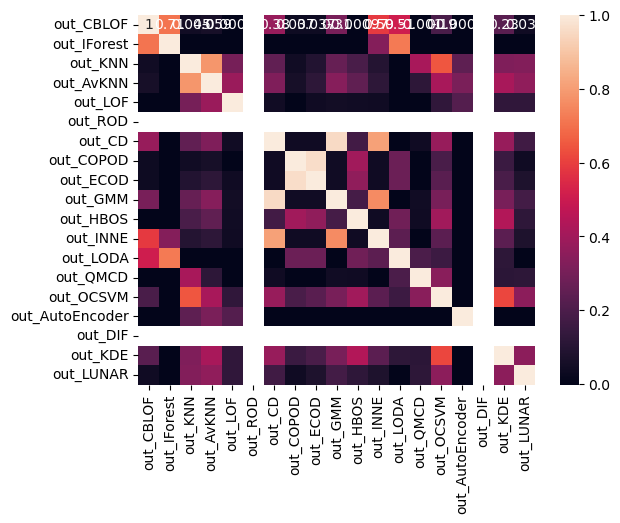

In [55]:
ax = sns.heatmap(df_small[out_algos].corr(), annot=True)

In [56]:
#M = cor(df_small[out_algos])
#corrplot(M)

In [57]:
df_small[out_algos].corr(method='pearson')

,out_CBLOF,out_IForest,out_KNN,out_AvKNN,out_LOF,out_ROD,out_CD,out_COPOD,out_ECOD,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD,out_OCSVM,out_AutoEncoder,out_DIF,out_KDE,out_LUNAR
out_CBLOF,1.000000,0.706928,0.045421,0.058515,-0.000932,NaN,0.375729,0.037487,0.037487,0.306357,-0.000974,0.587939,0.509415,-0.001014,0.191489,-0.000770,NaN,0.229990,0.038268
out_IForest,0.706928,1.000000,-0.000596,-0.000466,-0.000659,NaN,-0.000659,-0.000717,-0.000717,-0.000628,-0.000688,0.332364,0.720942,-0.000717,-0.000717,-0.000544,NaN,-0.000717,-0.000703
out_KNN,0.045421,-0.000596,1.000000,0.781629,0.300971,NaN,0.250680,0.045421,0.091686,0.262979,0.191797,0.093533,-0.000827,0.415539,0.646862,0.242948,NaN,0.323009,0.329433
out_AvKNN,0.058515,-0.000466,0.781629,1.000000,0.385336,NaN,0.321013,0.058515,0.117689,0.336726,0.245718,0.120043,-0.000646,0.117689,0.413558,0.311057,NaN,0.413558,0.361421
out_LOF,-0.000932,-0.000659,0.300971,0.385336,1.000000,NaN,0.044636,-0.000932,0.040919,0.046895,0.042663,0.041765,-0.000914,-0.000932,0.124621,0.219644,NaN,0.124621,0.127123
out_ROD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
out_CD,0.375729,-0.000659,0.250680,0.321013,0.044636,NaN,1.000000,0.040919,0.040919,0.953425,0.173338,0.809991,-0.000914,0.040919,0.375729,-0.000708,NaN,0.375729,0.169803
out_COPOD,0.037487,-0.000717,0.045421,0.058515,-0.000932,NaN,0.040919,1.000000,0.961499,0.043003,0.399737,0.038268,0.273842,-0.001014,0.191489,-0.000770,NaN,0.152988,0.038268
out_ECOD,0.037487,-0.000717,0.091686,0.117689,0.040919,NaN,0.040919,0.961499,1.000000,0.043003,0.359666,0.038268,0.273842,-0.001014,0.229990,-0.000770,NaN,0.191489,0.077530
out_GMM,0.306357,-0.000628,0.262979,0.336726,0.046895,NaN,0.953425,0.043003,0.043003,1.000000,0.181877,0.760058,-0.000872,0.043003,0.306357,-0.000675,NaN,0.306357,0.178171


In [58]:
mask = df.iloc[:, 7:12].eq(1).any(axis=1)
output_df = df[mask]

In [59]:
output_df

,time,source,service,action,agent,arn,tactic1,tactic2,out_CBLOF,out_IForest,...,out_GMM,out_HBOS,out_INNE,out_LODA,out_QMCD,out_OCSVM,out_AutoEncoder,out_DIF,out_KDE,out_LUNAR
21740,2018-09-26T18:09:00.000Z,15,1,0,14,1,Defense Evasion,-,0,0,...,0,0,0,0,0,1,0,0,1,1
21741,2018-09-28T13:39:07.000Z,15,18,3,1,1,Persistence,Initial Access,1,0,...,1,0,1,0,0,1,0,0,1,0
21742,2018-09-27T15:28:29.000Z,15,18,3,2,1,Persistence,Initial Access,1,0,...,1,0,1,0,0,1,0,0,1,0
21743,2018-09-30T17:30:21.000Z,17,18,3,3,1,Persistence,Initial Access,1,0,...,0,0,1,0,0,1,0,0,1,0
21744,2018-09-29T13:58:43.000Z,15,18,3,4,1,Persistence,Initial Access,1,0,...,0,0,1,0,0,1,0,0,1,0
21760,2018-09-26T20:49:11.000Z,15,14,4,0,1,Persistence,-,1,0,...,1,0,1,0,0,0,0,0,0,0
21761,2018-09-26T20:51:27.000Z,15,14,4,0,1,Persistence,-,1,0,...,1,0,1,0,0,0,0,0,0,0
21762,2018-09-26T20:50:57.000Z,15,14,4,0,1,Persistence,-,1,0,...,1,0,1,0,0,0,0,0,0,0
21763,2018-09-26T20:50:54.000Z,15,14,4,0,1,Persistence,-,1,0,...,1,0,1,0,0,0,0,0,0,0
21766,2018-09-27T19:27:11.000Z,37,11,6,22,2,Defense Evasion,-,0,0,...,1,1,0,0,0,1,0,0,1,1


In [60]:
anomalies = pd.read_csv('cloudtrail.csv')

In [61]:
pd.set_option('display.max_rows', 200)

In [62]:
# Define the indices of the rows you want to select
# Use iloc to select the specific rows
ddf = anomalies.iloc[row_indices]
ddf

,time,source,service,action,agent,arn,tactic1,tactic2
21740,2018-09-26T18:09:00.000Z,198.18.161.170,billingconsole.amazonaws.com,AWSPaymentInstrumentGateway.Delete,Null,arn:aws:iam::123456789012:root,Defense Evasion,-
21741,2018-09-28T13:39:07.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21742,2018-09-27T15:28:29.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21743,2018-09-30T17:30:21.000Z,223.0.113.35,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21744,2018-09-29T13:58:43.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21751,2018-12-19T20:02:32.000Z,203.0.113.55,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (iPhone; CPU iPhone OS 12_0_1 like...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21759,2018-12-24T15:21:11.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (iPad; CPU OS 12_1 like Mac OS X) ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21760,2018-09-26T20:49:11.000Z,198.18.161.170,organizations.amazonaws.com,CreateAccount,AWS Organizations Console- aws-internal/3 aws-...,arn:aws:iam::123456789012:root,Persistence,-
21761,2018-09-26T20:51:27.000Z,198.18.161.170,organizations.amazonaws.com,CreateAccount,AWS Organizations Console- aws-internal/3 aws-...,arn:aws:iam::123456789012:root,Persistence,-
21762,2018-09-26T20:50:57.000Z,198.18.161.170,organizations.amazonaws.com,CreateAccount,AWS Organizations Console- aws-internal/3 aws-...,arn:aws:iam::123456789012:root,Persistence,-


In [63]:
anomalies.to_excel('anomalies-without-PCA.xlsx', index=False)

In [64]:
# Filter rows where the cell value in 'action' does not start with 'Describe'
#subset = selected_rows.loc[~selected_rows['action'].str.startswith('Describe')]
subset = ddf[ddf['tactic1'] != 'Discovery']
# Printing the filtered DataFrame
subset

,time,source,service,action,agent,arn,tactic1,tactic2
21740,2018-09-26T18:09:00.000Z,198.18.161.170,billingconsole.amazonaws.com,AWSPaymentInstrumentGateway.Delete,Null,arn:aws:iam::123456789012:root,Defense Evasion,-
21741,2018-09-28T13:39:07.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21742,2018-09-27T15:28:29.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21743,2018-09-30T17:30:21.000Z,223.0.113.35,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21744,2018-09-29T13:58:43.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,AWSBFF BFFiOS/1.19.6 (1015) Mobile iOS/11.4.1 ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21751,2018-12-19T20:02:32.000Z,203.0.113.55,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (iPhone; CPU iPhone OS 12_0_1 like...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21759,2018-12-24T15:21:11.000Z,198.18.161.170,signin.amazonaws.com,ConsoleLogin,Mozilla/5.0 (iPad; CPU OS 12_1 like Mac OS X) ...,arn:aws:iam::123456789012:root,Persistence,Initial Access
21760,2018-09-26T20:49:11.000Z,198.18.161.170,organizations.amazonaws.com,CreateAccount,AWS Organizations Console- aws-internal/3 aws-...,arn:aws:iam::123456789012:root,Persistence,-
21761,2018-09-26T20:51:27.000Z,198.18.161.170,organizations.amazonaws.com,CreateAccount,AWS Organizations Console- aws-internal/3 aws-...,arn:aws:iam::123456789012:root,Persistence,-
21762,2018-09-26T20:50:57.000Z,198.18.161.170,organizations.amazonaws.com,CreateAccount,AWS Organizations Console- aws-internal/3 aws-...,arn:aws:iam::123456789012:root,Persistence,-
